In [520]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score 

import statsmodels.api as sm
from scipy import stats

In [543]:
abbrev = pd.read_csv("data/abbrev.csv")
abbrev.columns

Index(['Unnamed: 0', 'household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population',
       'pop_65_plus', 'health_ins', 'county', 'state', 'area',
       'domestic_passengers', 'intl_passengers', 'deaths', 'cases_march1',
       'cases_march15', 'cases_april1', 'ten_plus', 'order', 'density',
       'death_prc'],
      dtype='object')

In [544]:
abbrev = abbrev.drop('Unnamed: 0', axis=1)

In [552]:
predictors = ['household_size', 'empl_agriculture', 'empl_professional','empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
              'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population', 'pop_65_plus', 'health_ins', 'area', 
              'domestic_passengers', 'intl_passengers', 'ten_plus', 'order', 'density', 'cases_march1',
             'cases_march15']
# omitting april1 cases data, since it's pretty much perfectly correlated...

predictors_noCaseData = predictors.copy()
predictors_noCaseData.remove('cases_march1')
predictors_noCaseData.remove('cases_march15')
predictors_noCaseData

['household_size',
 'empl_agriculture',
 'empl_professional',
 'empl_social',
 'empl_services',
 'empl_manufacturing',
 'empl_retail',
 'prc_fam_poverty',
 'avg_income',
 'prc_public_transp',
 'population',
 'pop_65_plus',
 'health_ins',
 'area',
 'domestic_passengers',
 'intl_passengers',
 'ten_plus',
 'order',
 'density']

In [524]:
import rpy2.robjects as robjects
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "county". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))
/home/anna/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:63: UserWarning: Error while trying to convert the column "state". Fall back to string conversion. The error is: module 'pandas' has no attribute 'NA'
  % (name, str(e)))


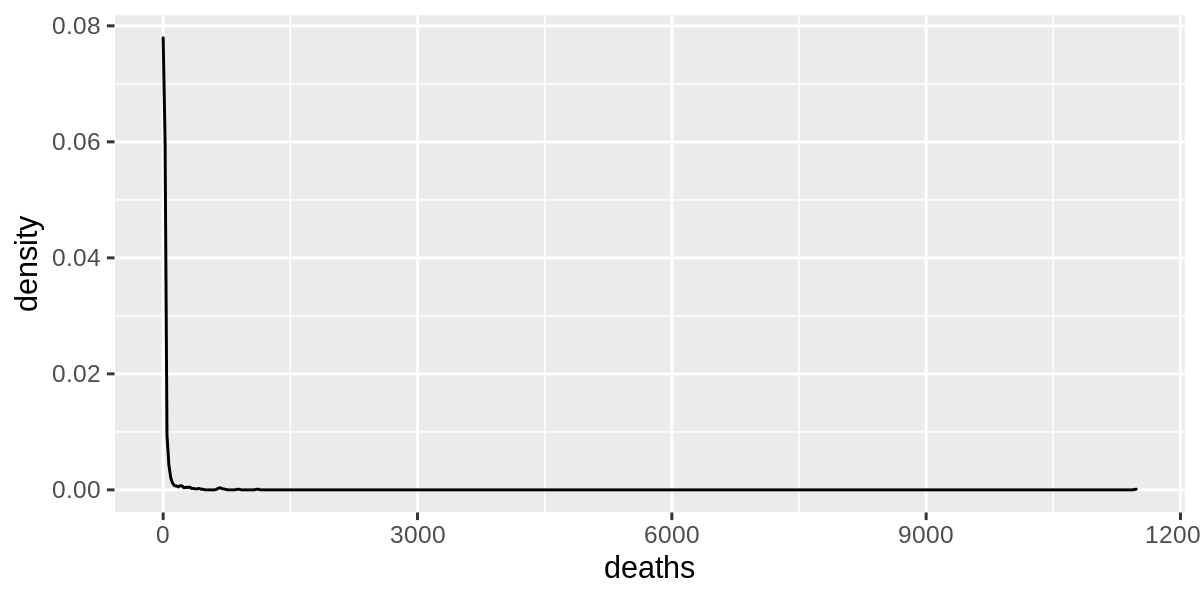

In [525]:
%%R -i abbrev -w 6 -h 3 --units in -r 200

library(ggplot2)
ggplot(abbrev, aes(deaths)) + geom_density()

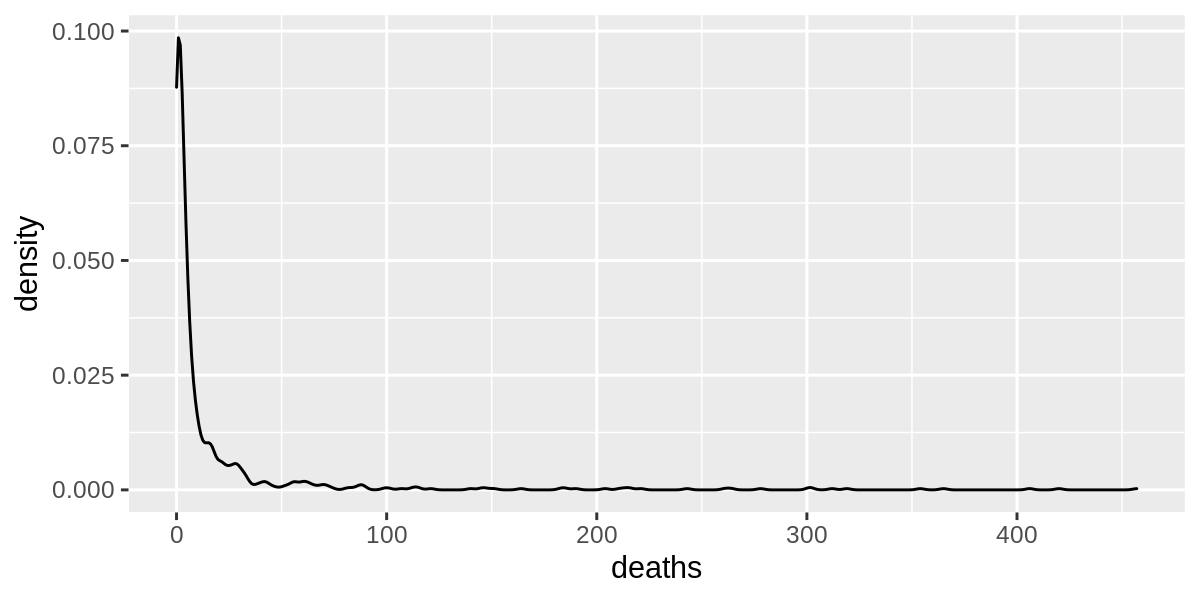

In [526]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths < 600,], aes(deaths)) + geom_density()

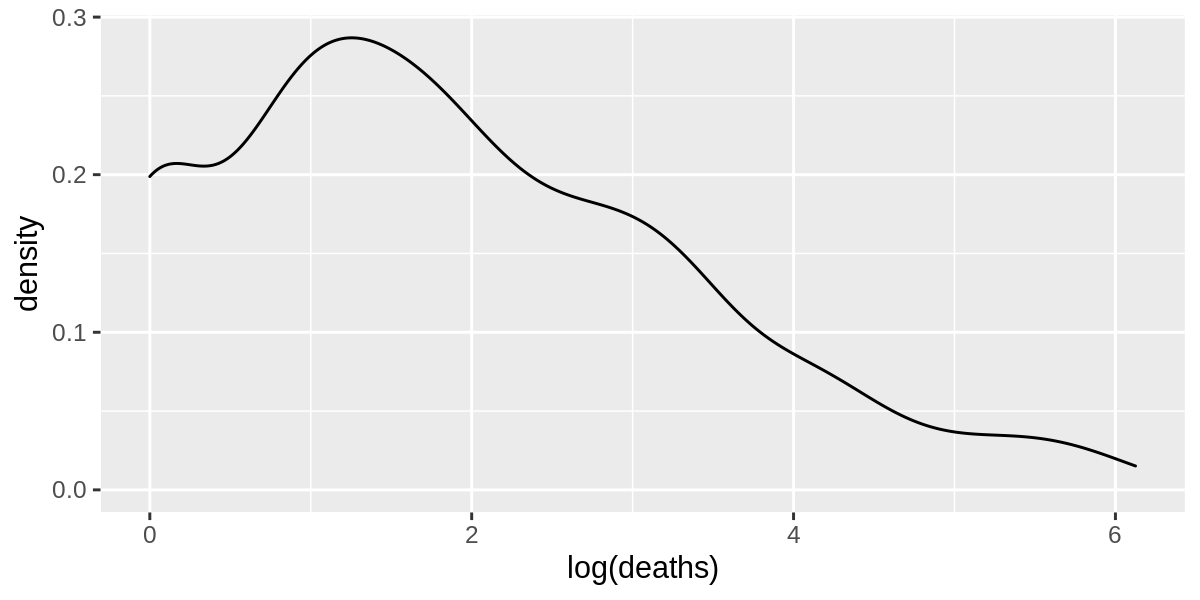

In [527]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths < 600,], aes(log(deaths))) + geom_density()

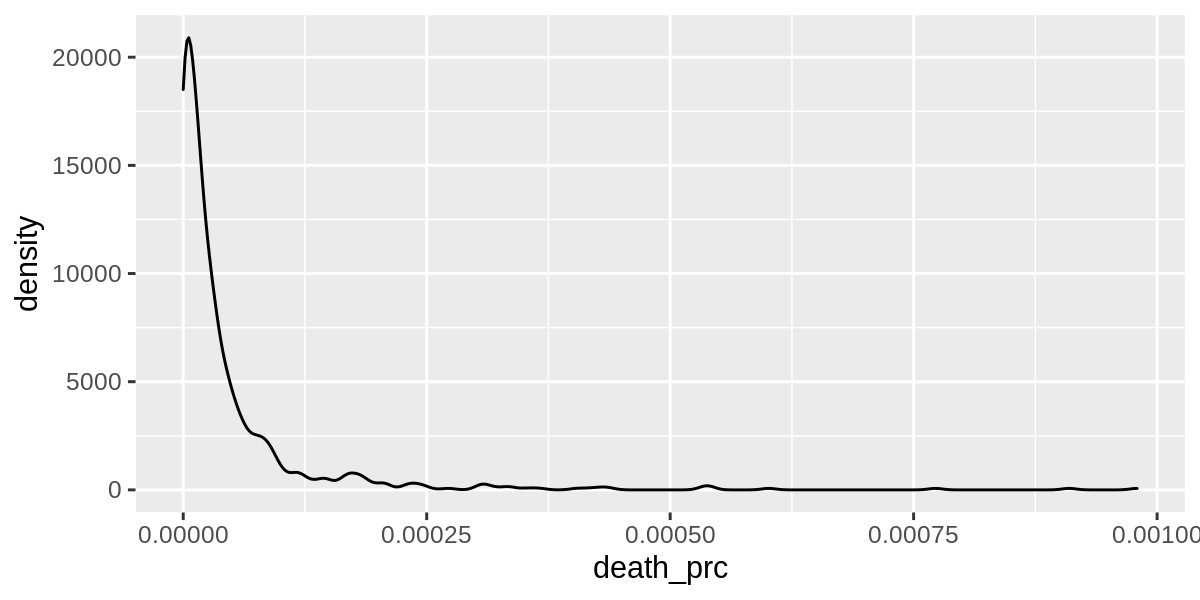

In [528]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths < 600,], aes(death_prc)) + geom_density()

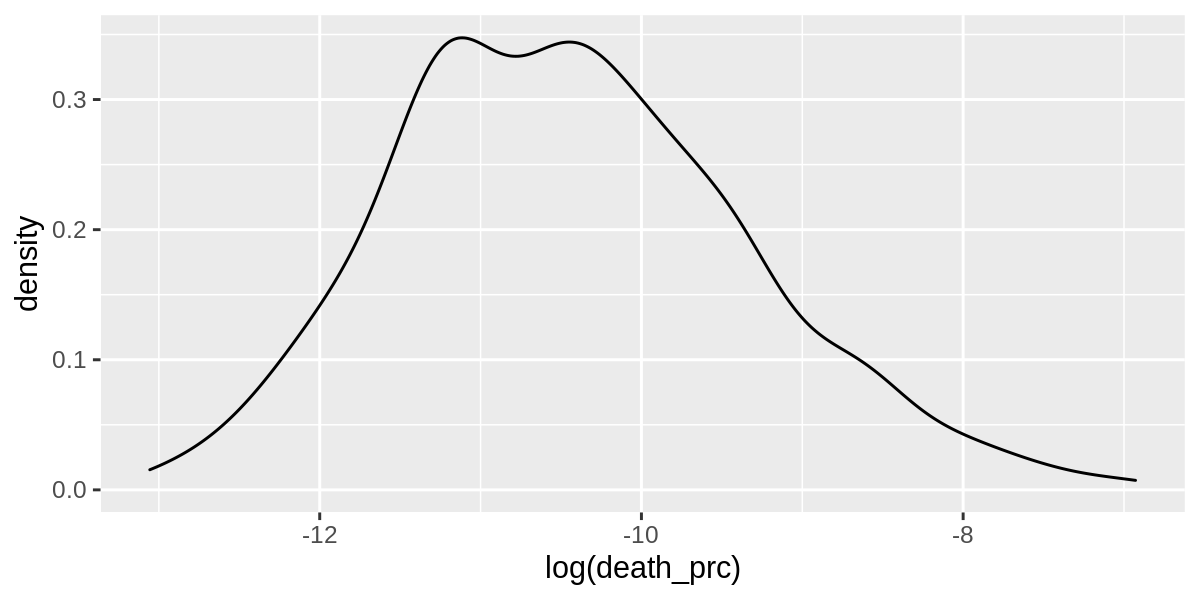

In [529]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev[abbrev$deaths < 600,], aes(log(death_prc))) + geom_density()

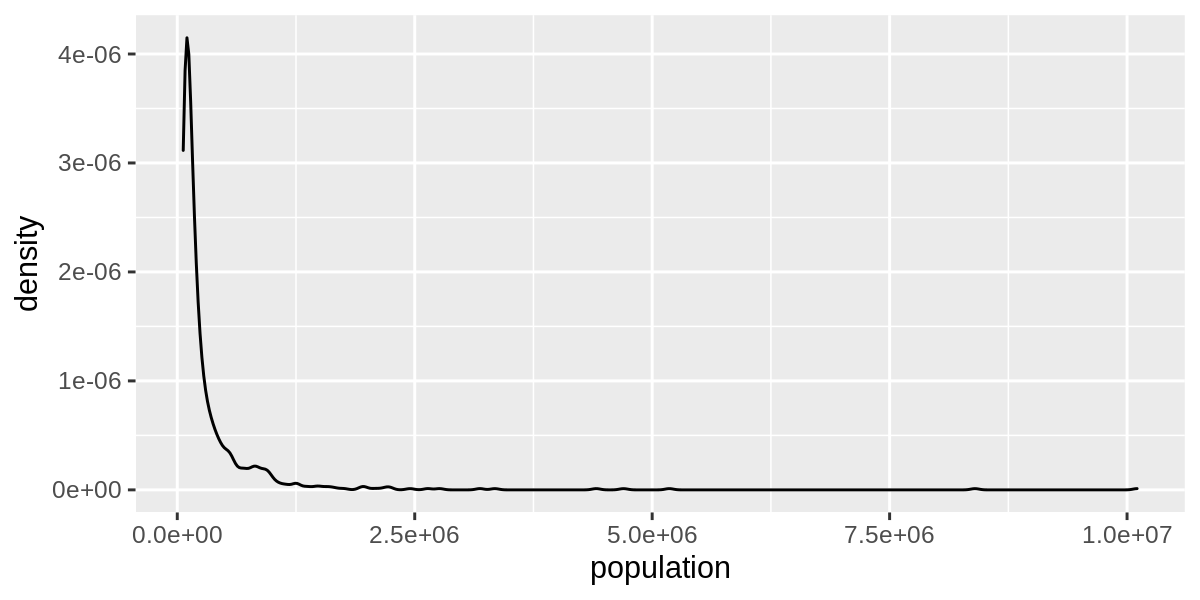

In [530]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(population)) + geom_density()
# try log-transforming population

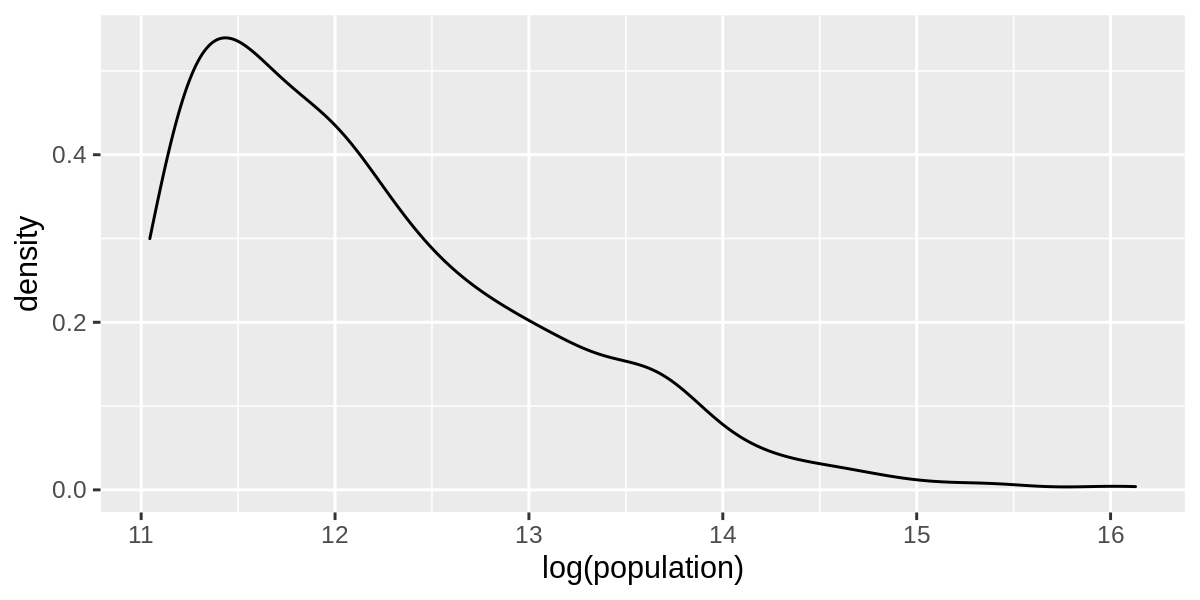

In [531]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(log(population))) + geom_density()

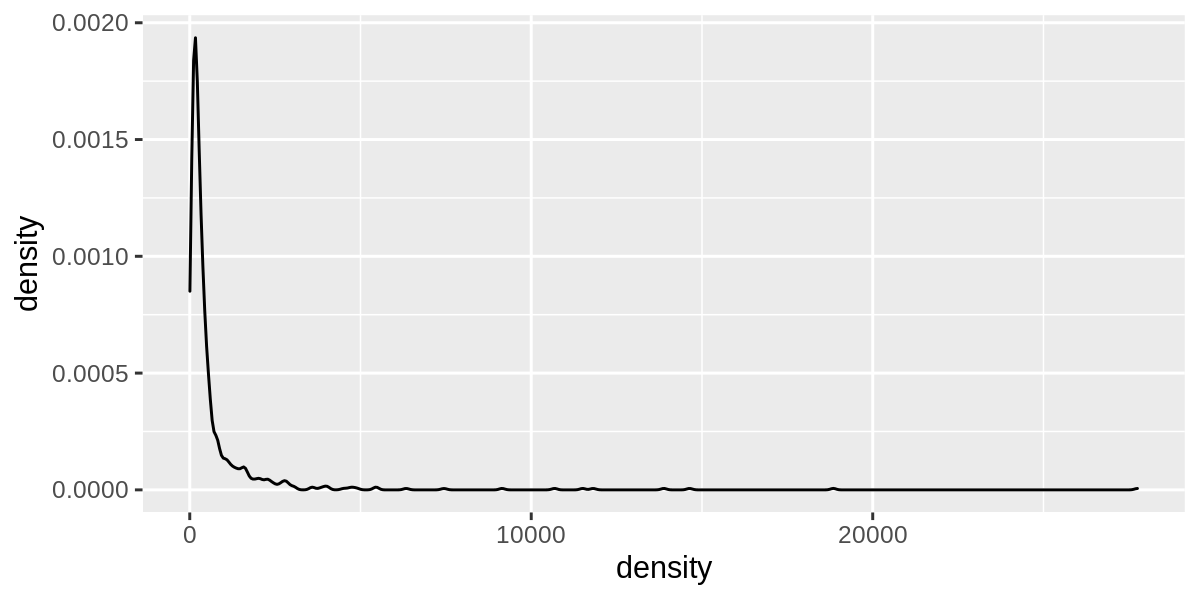

In [532]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(density)) + geom_density()

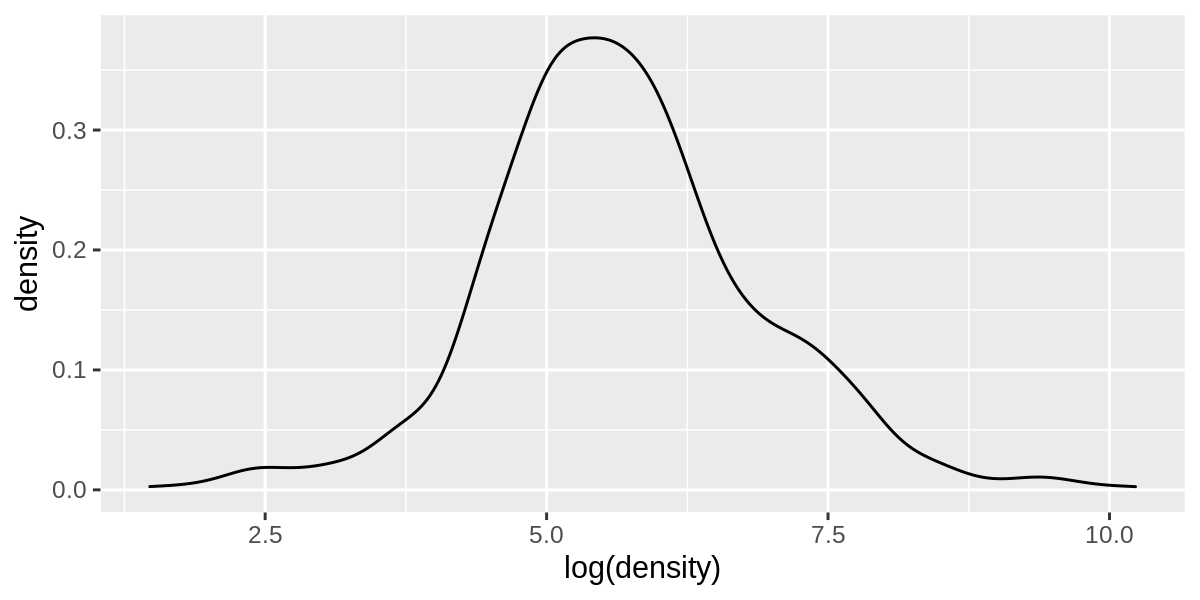

In [533]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(log(density))) + geom_density()
# much more normal! try log transforming density, too

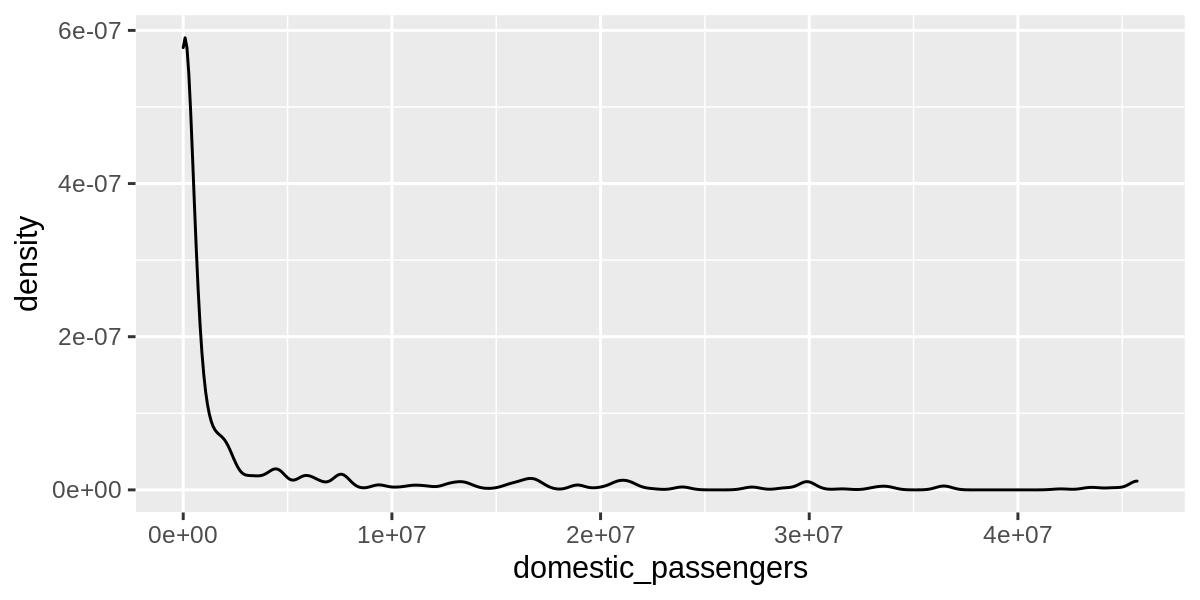

In [534]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(domestic_passengers)) + geom_density()
# log transform domestic_passengers, too

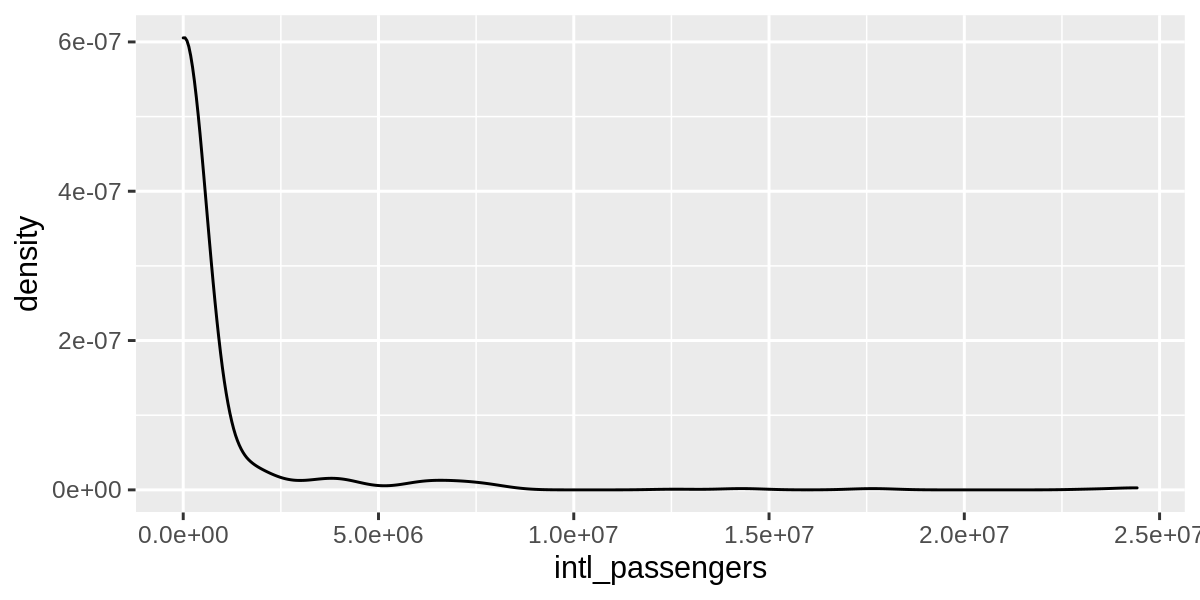

In [535]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(intl_passengers)) + geom_density()
# and international passengers

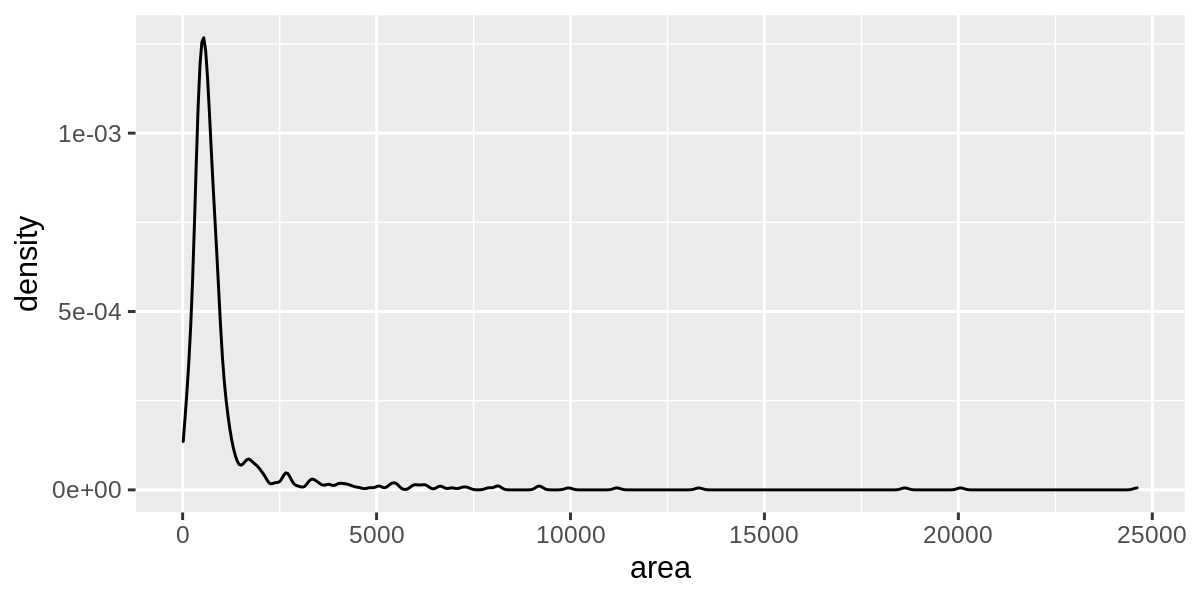

In [536]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev, aes(area)) + geom_density()
# and area

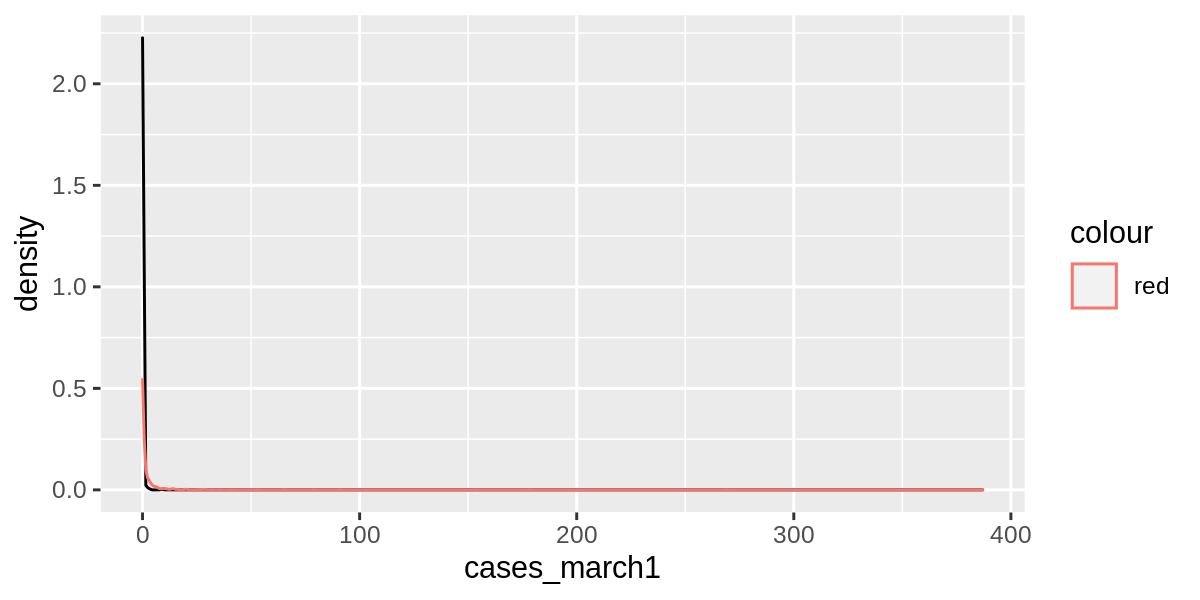

In [537]:
%%R -w 6 -h 3 --units in -r 200

ggplot(abbrev) + geom_density(aes(cases_march1)) +
geom_density(aes(cases_march15, color="red")) 
# and case numbers

In [546]:
abbrev[["density", "area", "population", "intl_passengers", "domestic_passengers", 
       "cases_march1", "cases_march15"]].describe()

,density,area,population,intl_passengers,domestic_passengers,cases_march1,cases_march15
count,823.000000,823.000000,8.230000e+02,8.230000e+02,8.230000e+02,823.000000,823.000000
mean,680.411847,1072.085128,3.381622e+05,6.392778e+05,4.013013e+06,0.034022,3.403402
std,1702.363895,1819.334447,6.444629e+05,2.440155e+06,8.866051e+06,0.377351,19.561994
min,4.372986,15.030000,6.260700e+04,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,140.207786,439.090000,9.591600e+04,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,271.494496,631.520000,1.593370e+05,0.000000e+00,2.980000e+05,0.000000,0.000000
75%,557.809007,911.795000,3.306250e+05,0.000000e+00,2.180000e+06,0.000000,2.000000
max,27750.695523,24607.900000,1.010552e+07,2.442400e+07,4.571100e+07,9.000000,387.000000


In [553]:
abbrev.loc[abbrev["intl_passengers"] == 0, "intl_passengers"] = 0.0000001
abbrev.loc[abbrev["domestic_passengers"] == 0, "domestic_passengers"] = 0.0000001
abbrev.loc[abbrev["cases_march1"] == 0, "cases_march1"] = 0.0000001
abbrev.loc[abbrev["cases_march15"] == 0, "cases_march15"] = 0.0000001

transform = ["population", "density", "intl_passengers", "domestic_passengers", "area", 
            "cases_march1", "cases_march15"]
for field in transform:
    abbrev["log_"+field] = np.log1p(abbrev[field])

In [554]:
abbrev.columns

Index(['household_size', 'empl_agriculture', 'empl_professional',
       'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail',
       'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'population',
       'pop_65_plus', 'health_ins', 'county', 'state', 'area',
       'domestic_passengers', 'intl_passengers', 'deaths', 'cases_march1',
       'cases_march15', 'cases_april1', 'ten_plus', 'order', 'density',
       'death_prc', 'log_population', 'log_density', 'log_intl_passengers',
       'log_domestic_passengers', 'log_area', 'log_cases_march1',
       'log_cases_march15'],
      dtype='object')

In [556]:
log_predictors = predictors.copy()
for field in transform:
    log_predictors.remove(field)
    log_predictors.append("log_"+field)
print(log_predictors)

['household_size', 'empl_agriculture', 'empl_professional', 'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail', 'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'pop_65_plus', 'health_ins', 'ten_plus', 'order', 'log_population', 'log_density', 'log_intl_passengers', 'log_domestic_passengers', 'log_area', 'log_cases_march1', 'log_cases_march15']


In [557]:
log_predictors_noCaseData = log_predictors.copy()
log_predictors_noCaseData.remove('log_cases_march1')
log_predictors_noCaseData.remove('log_cases_march15')
print(log_predictors_noCaseData)

['household_size', 'empl_agriculture', 'empl_professional', 'empl_social', 'empl_services', 'empl_manufacturing', 'empl_retail', 'prc_fam_poverty', 'avg_income', 'prc_public_transp', 'pop_65_plus', 'health_ins', 'ten_plus', 'order', 'log_population', 'log_density', 'log_intl_passengers', 'log_domestic_passengers', 'log_area']


### Linear Regression

In [569]:
# dependent variable = deaths

lrm_noCases = LinearRegression().fit(abbrev[predictors_noCaseData], abbrev["deaths"])
lrm = LinearRegression().fit(abbrev[predictors], abbrev["deaths"])
lrm_log_noCases = LinearRegression().fit(abbrev[log_predictors_noCaseData], abbrev["deaths"])
lrm_log = LinearRegression().fit(abbrev[log_predictors], abbrev["deaths"])

print("no case data R2: ", lrm_noCases.score(abbrev[predictors_noCaseData], abbrev["deaths"]), 
      "\nwith case data R2: ", lrm.score(abbrev[predictors], abbrev["deaths"]), 
      "\nlog predictors no case data R2: ", lrm_log_noCases.score(abbrev[log_predictors_noCaseData], abbrev["deaths"]), 
      "\nlog predictors with case data R2: ", lrm_log.score(abbrev[log_predictors], abbrev["deaths"]))

no case data R2:  0.5403875409334878 
with case data R2:  0.7291188118909916 
log predictors no case data R2:  0.3469340778819421 
log predictors with case data R2:  0.36082225739594675


In [583]:
print("variable\tcoeff with cases\t coeff without cases")
for a,b,c in zip(predictors, lrm.coef_, lrm_noCases.coef_):
    print(a, "\t", b, "\t", c)
print(predictors[19], "\t", lrm.coef_[19], "\tNA")
print(predictors[20], "\t", lrm.coef_[20], "\tNA")

variable	coeff with cases	 coeff without cases
household_size 	 2.487698703777482e-05 	 3.171666279309252e-05
empl_agriculture 	 -2.9430952143025653e-06 	 -2.7426027984273755e-06
empl_professional 	 -5.861482619550153e-06 	 -7.117677154165564e-06
empl_social 	 7.794088057111265e-08 	 2.1019179385634522e-07
empl_services 	 -3.125447678088393e-06 	 -2.864087481068826e-06
empl_manufacturing 	 -8.005280939224989e-07 	 -8.704173412774942e-07
empl_retail 	 -6.074674239298982e-07 	 -8.273001341323642e-07
prc_fam_poverty 	 2.505614507715019e-06 	 2.112779751711629e-06
avg_income 	 6.32052555404721e-10 	 7.450025119209024e-10
prc_public_transp 	 2.770641779967051e-06 	 4.106022901708304e-06
population 	 -1.2672441956962824e-11 	 -7.90425028886007e-12
pop_65_plus 	 1.5633471090654846e-06 	 1.8977020434927175e-06
health_ins 	 2.0737891317987944e-06 	 1.8792142987936624e-06
area 	 -2.620394581083254e-09 	 -3.2416886462494946e-09
domestic_passengers 	 -1.8438824779569447e-12 	 -2.953342578793754e-1

In [571]:
# dependent variable: deaths as percentage of population

lrm_noCases = LinearRegression().fit(abbrev[predictors_noCaseData], abbrev["death_prc"])
lrm = LinearRegression().fit(abbrev[predictors], abbrev["death_prc"])
lrm_log_noCases = LinearRegression().fit(abbrev[log_predictors_noCaseData], abbrev["death_prc"])
lrm_log = LinearRegression().fit(abbrev[log_predictors], abbrev["death_prc"])

print("no case data R2: ", lrm_noCases.score(abbrev[predictors_noCaseData], abbrev["death_prc"]), 
      "\nwith case data R2: ", lrm.score(abbrev[predictors], abbrev["death_prc"]), 
      "\nlog predictors no case data R2: ", lrm_log_noCases.score(abbrev[log_predictors_noCaseData], abbrev["death_prc"]), 
      "\nlog predictors with case data R2: ", lrm_log.score(abbrev[log_predictors], abbrev["death_prc"]))

no case data R2:  0.4170396251940929 
with case data R2:  0.46979718300203566 
log predictors no case data R2:  0.36017187095163405 
log predictors with case data R2:  0.39921787240500944


#### Linear Regression with TransformedTargetRegressor

transforms the dependent variable (here using natural logarithm) before regression

+ https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
+ https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html#sklearn.compose.TransformedTargetRegressor

In [ ]:
lrm_noCases = LinearRegression().fit(abbrev[predictors_noCaseData], abbrev["death_prc"])
lrm = LinearRegression().fit(abbrev[predictors], abbrev["death_prc"])
lrm_log_noCases = LinearRegression().fit(abbrev[log_predictors_noCaseData], abbrev["death_prc"])
lrm_log = LinearRegression().fit(abbrev[log_predictors], abbrev["death_prc"])

print("no case data R2: ", lrm_noCases.score(abbrev[predictors_noCaseData], abbrev["death_prc"]), 
      "\nwith case data R2: ", lrm.score(abbrev[predictors], abbrev["death_prc"]), 
      "\nlog predictors no case data R2: ", lrm_log_noCases.score(abbrev[log_predictors_noCaseData], abbrev["death_prc"]), 
      "\nlog predictors with case data R2: ", lrm_log.score(abbrev[log_predictors], abbrev["death_prc"]))

In [573]:
ttr = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)

ttr.fit(abbrev[predictors], abbrev["deaths"])
ttr_lrm = ttr.score(abbrev[predictors], abbrev["deaths"])

ttr.fit(abbrev[predictors_noCaseData], abbrev["deaths"])
ttr_lrm_noCases = ttr.score(abbrev[predictors_noCaseData], abbrev["deaths"])

ttr.fit(abbrev[log_predictors], abbrev["deaths"])
ttr_log_lrm = ttr.score(abbrev[log_predictors], abbrev["deaths"])

ttr.fit(abbrev[log_predictors_noCaseData], abbrev["deaths"])
ttr_log_lrm_noCases = ttr.score(abbrev[log_predictors_noCaseData], abbrev["deaths"])

print("no case data R2: ", ttr_lrm_noCases, 
      "\nwith case data R2: ", ttr_lrm, 
      "\nlog predictors no case data R2: ", ttr_log_lrm_noCases, 
      "\nlog predictors with case data R2: ", ttr_log_lrm)

no case data R2:  -7.365014775898484 
with case data R2:  -29.07398431942453 
log predictors no case data R2:  0.7987467790828905 
log predictors with case data R2:  0.9107661480251654


In [587]:
# compare those with with r2=.910 and r2=0.799 (log predictors, dependent variable=deaths)
ttr1 = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)
ttr1.fit(abbrev[log_predictors], abbrev["deaths"])

ttr2 = TransformedTargetRegressor(regressor=LinearRegression(), func=np.log1p, inverse_func=np.expm1)
ttr2.fit(abbrev[log_predictors_noCaseData], abbrev["deaths"])

print("variable\tcoeff with cases\tcoeff without cases")
for a, b,c in zip(log_predictors, ttr1.regressor_.coef_, ttr2.regressor_.coef_):
    print(a, "\t", b, "\t", c)
print(log_predictors[19], "\t", ttr1.regressor_.coef_[19], "\tNA")
print(log_predictors[20], "\t",ttr1.regressor_.coef_[20], "\tNA")

variable	coeff with cases	coeff without cases
household_size 	 -0.07461694854165 	 -0.04691288014234592
empl_agriculture 	 -0.007032589221471929 	 -0.005979153520889142
empl_professional 	 -0.06096596824802733 	 -0.0628892566010829
empl_social 	 -0.009847850656956286 	 -0.00976149206737905
empl_services 	 -0.05086978127858835 	 -0.051256002335505195
empl_manufacturing 	 0.001777502782660656 	 0.0009574437929409862
empl_retail 	 -0.004696861285487878 	 -0.0069614241998900706
prc_fam_poverty 	 0.0359785859246318 	 0.03687530526411324
avg_income 	 9.632072089581199e-06 	 1.1303337634647874e-05
prc_public_transp 	 0.04154283168340194 	 0.04577093800003971
pop_65_plus 	 0.02650195156822042 	 0.028661266792765885
health_ins 	 0.026994307723320465 	 0.02527595559892055
ten_plus 	 0.06848577514774201 	 0.07369166199385259
order 	 0.021325396297056542 	 0.021220091391630967
log_population 	 -0.8265739322633547 	 -0.6570325229904452
log_density 	 1.5371296627700108 	 1.3886426892339285
log_intl_

while the valaues of the coefficients change between model that uses case data and the one that doesn't, for most of the variables the polarity of the coefficient is the same and the value isn't wildly different between the two models

In [606]:
exam = abbrev.copy()
exam["fitted"] = ttr1.regressor_.predict(abbrev[log_predictors])
exam["pred"] = ttr1.inverse_func(ttr1.regressor_.predict(abbrev[log_predictors]))

exam["fitted_noCases"] = ttr2.regressor_.predict(abbrev[log_predictors_noCaseData])
exam["pred_noCases"] = ttr2.inverse_func(ttr2.regressor_.predict(abbrev[log_predictors_noCaseData]))

In [607]:
exam[["pred", "pred_noCases", "deaths"]].describe()

,pred,pred_noCases,deaths
count,823.000000,823.000000,823.000000
mean,23.552931,21.180792,38.071689
std,298.952616,232.248322,408.374275
min,-0.622616,-0.676993,0.000000
25%,1.446984,1.503690,1.000000
50%,3.675188,3.820854,3.000000
75%,9.171934,9.301896,13.000000
max,8523.793739,6585.497631,11477.000000


R[write to console]: `geom_smooth()` using formula 'y ~ x'



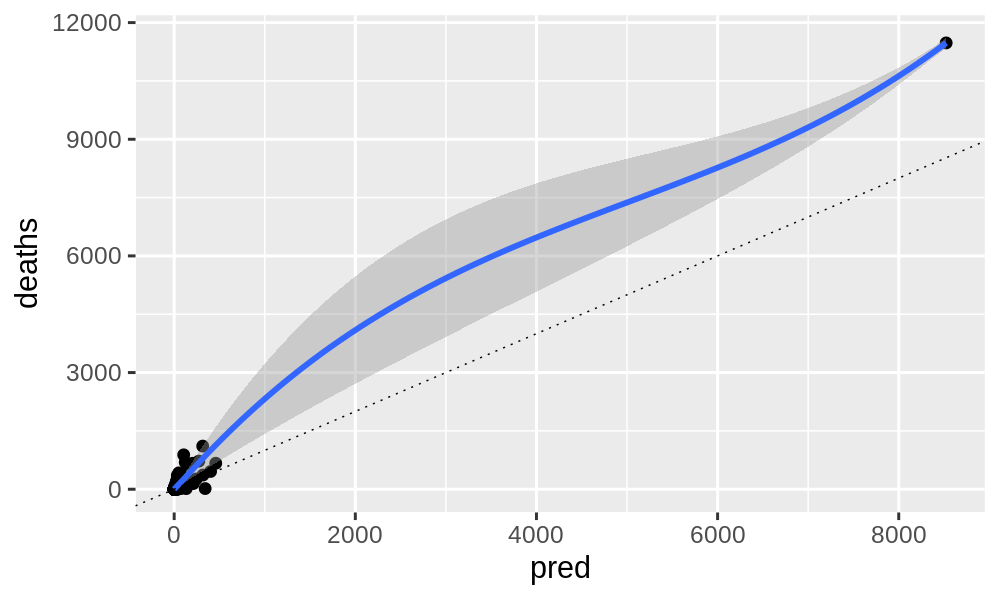

In [619]:
%%R -i exam -w 5 -h 3 --units in -r 200

ggplot(exam, aes(x=pred, y=deaths)) + geom_jitter() + 
geom_smooth(method = "loess", size = 1) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



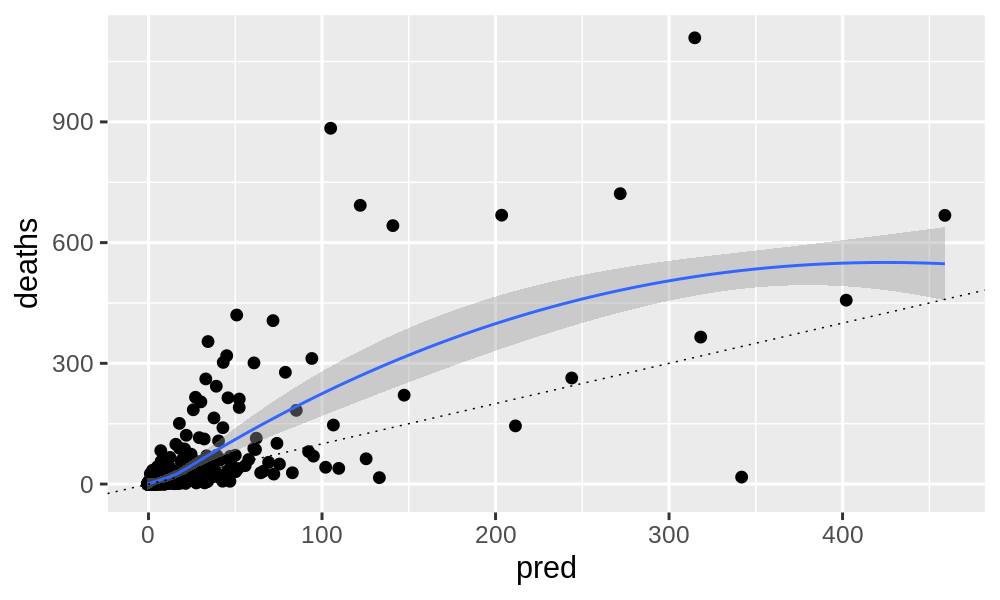

In [617]:
%%R -w 5 -h 3 --units in -r 200

ggplot(exam[exam$count != "New York County",], aes(x=pred, y=deaths)) + geom_jitter() + 
geom_smooth(method = "loess", size = .5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



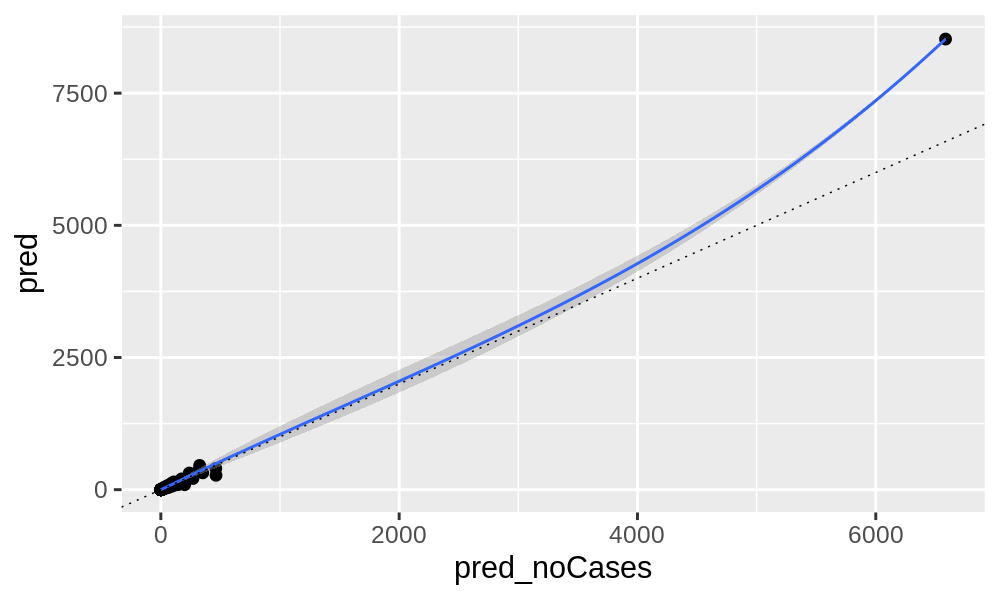

In [615]:
%%R -w 5 -h 3 --units in -r 200

ggplot(exam, aes(x=pred_noCases, y=pred)) + geom_jitter() + 
geom_smooth(method = "loess", size = .5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

R[write to console]: `geom_smooth()` using formula 'y ~ x'



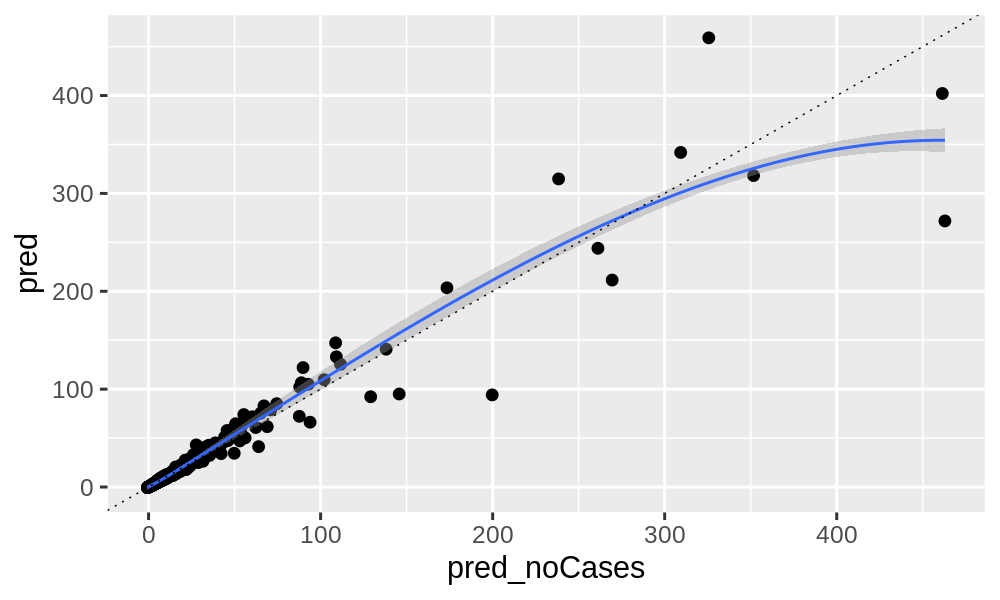

In [620]:
%%R -w 5 -h 3 --units in -r 200

ggplot(exam[exam$county != "New York County",], aes(x=pred_noCases, y=pred)) + geom_jitter() + 
geom_smooth(method = "loess", size = .5) +
geom_abline(slope=1, intercept=0, size = 0.25, linetype="dotted")

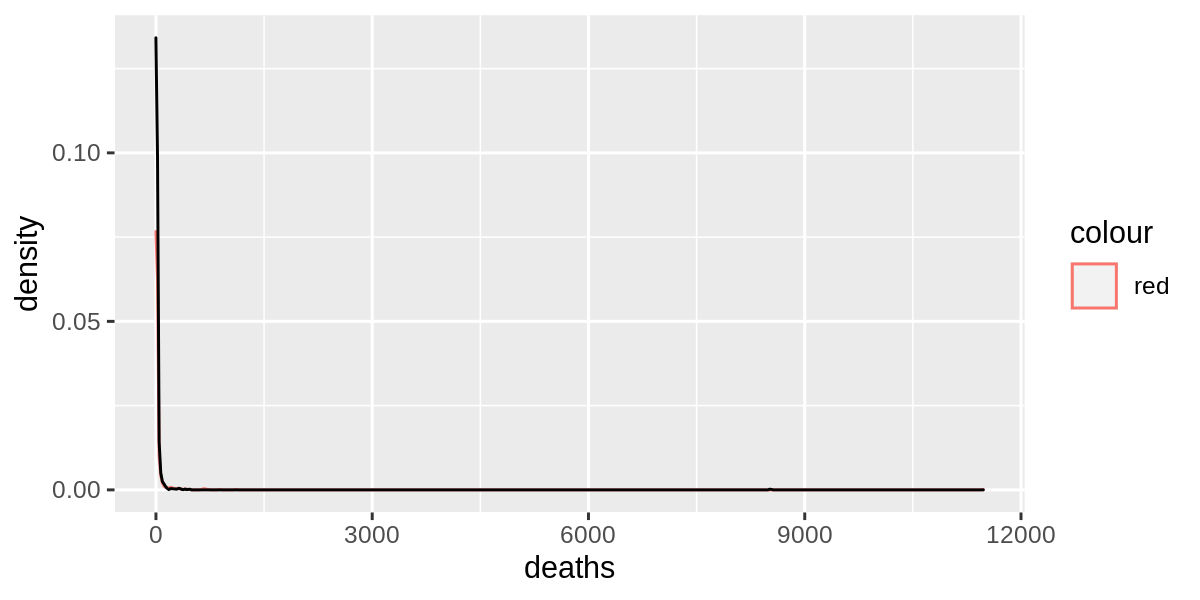

In [600]:
%%R -w 6 -h 3 --units in -r 200

ggplot(exam) + geom_density(aes(deaths, color="red")) + geom_density(aes(pred))

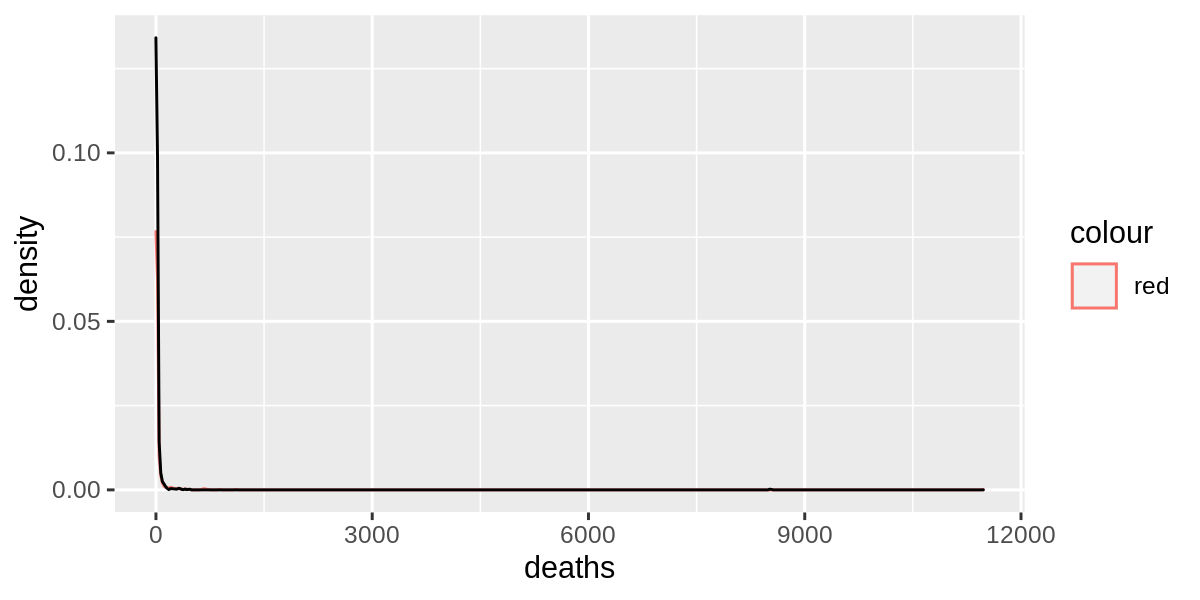

In [483]:
%%R -i exam -w 6 -h 3 --units in -r 200

ggplot(exam) + geom_density(aes(deaths, color="red")) + geom_density(aes(pred))

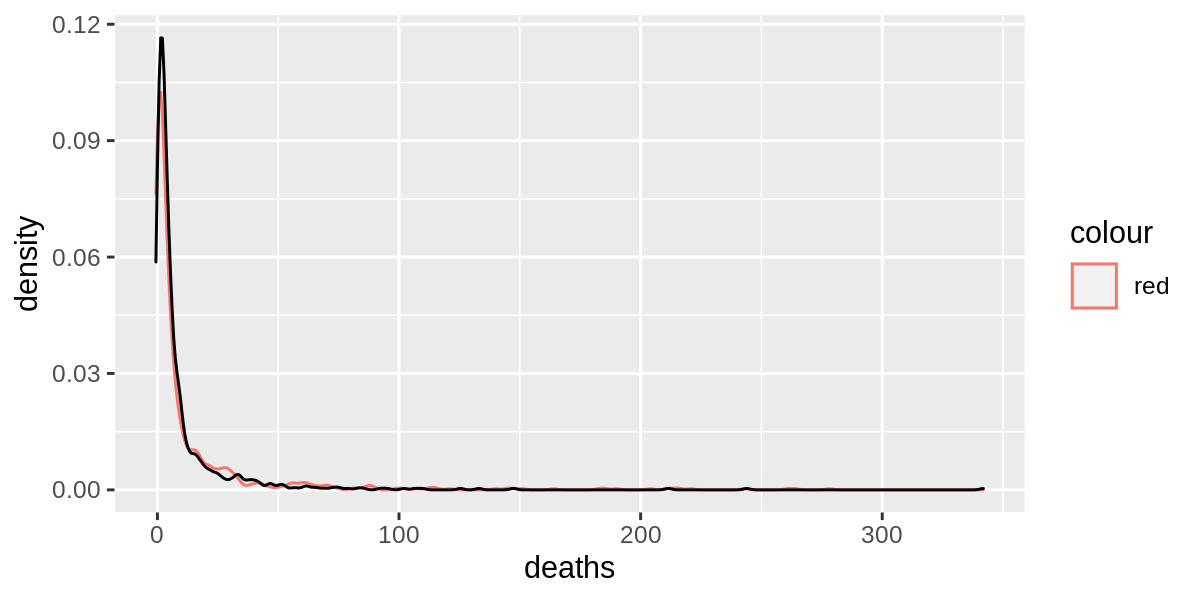

In [484]:
%%R -i exam -w 6 -h 3 --units in -r 200

ggplot(exam[exam$deaths < 300,]) + geom_density(aes(deaths, color="red")) + geom_density(aes(pred))

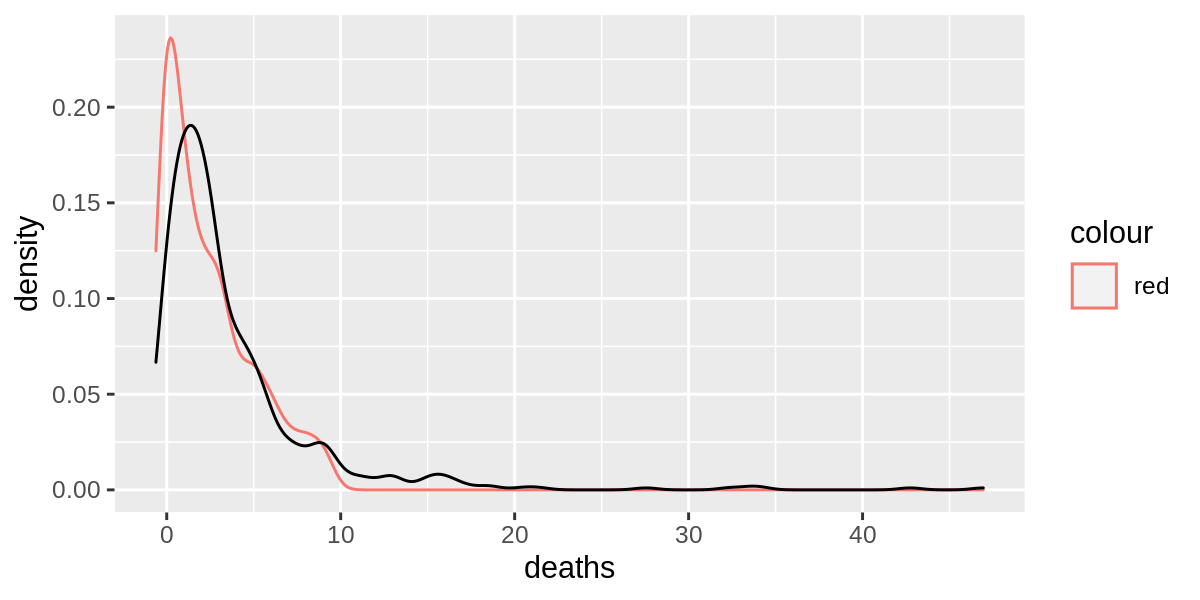

In [601]:
%%R -i exam -w 6 -h 3 --units in -r 200

ggplot(exam[exam$deaths < 10,]) + geom_density(aes(deaths, color="red")) + geom_density(aes(pred))

In [623]:
# check the model using R-style plots
# https://robert-alvarez.github.io/2018-06-04-diagnostic_plots/
# https://medium.com/@vikashrajluhaniwal/simulating-replicating-r-regression-plot-in-python-using-sklearn-4ee48a15b67

import seaborn as sns
import matplotlib.pyplot as plt
#import scipy.stats as stats

#import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
plt.style.use('seaborn') # pretty matplotlib plots
plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

In [624]:
exam["residuals"] = exam["deaths"] - exam["pred"]
exam["residuals_noCases"] = exam["deaths"] - exam["pred_noCases"]

In [625]:
exam[["residuals", "residuals_noCases", "deaths", "pred", "pred_noCases"]].describe()

,residuals,residuals_noCases,deaths,pred,pred_noCases
count,823.000000,823.000000,823.000000,823.000000,823.000000
mean,14.518758,16.890896,38.071689,23.552931,21.180792
std,121.121585,182.420556,408.374275,298.952616,232.248322
min,-324.834250,-292.300381,0.000000,-0.622616,-0.676993
25%,-1.946298,-2.105766,1.000000,1.446984,1.503690
50%,0.031416,-0.025790,3.000000,3.675188,3.820854
75%,3.257916,2.947598,13.000000,9.171934,9.301896
max,2953.206261,4891.502369,11477.000000,8523.793739,6585.497631


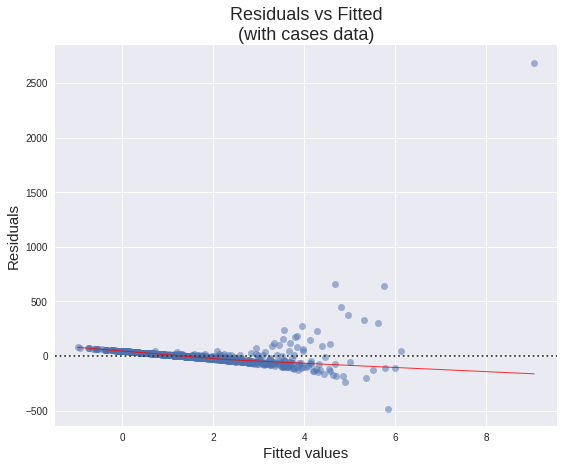

In [627]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam["fitted"], exam["residuals"], data=exam,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(with cases data)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

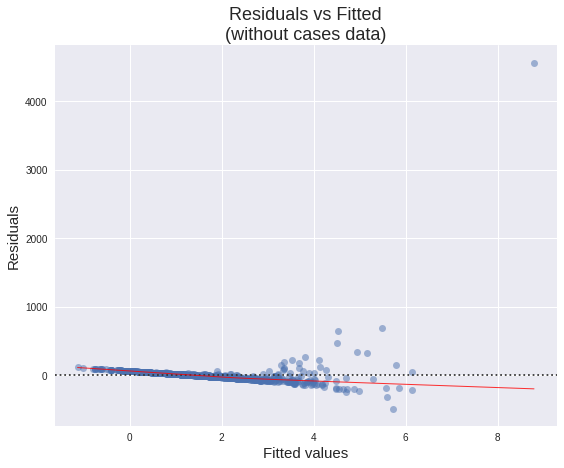

In [629]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam["fitted_noCases"], exam["residuals_noCases"], data=exam,
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(without cases data)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

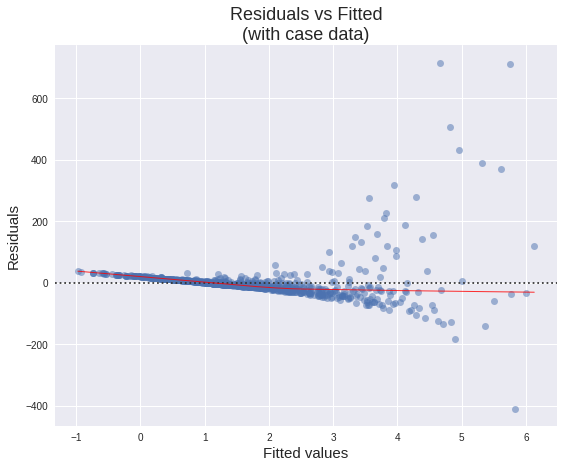

In [631]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam.loc[exam["deaths"]<5000,"fitted"], 
                                  exam.loc[exam["deaths"]<5000,"residuals"], 
                                  data=exam.loc[exam["deaths"]<5000,],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(with case data)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

# looking at the same (still heterskedasticitic) when removing NY County (a spectacular outlier)

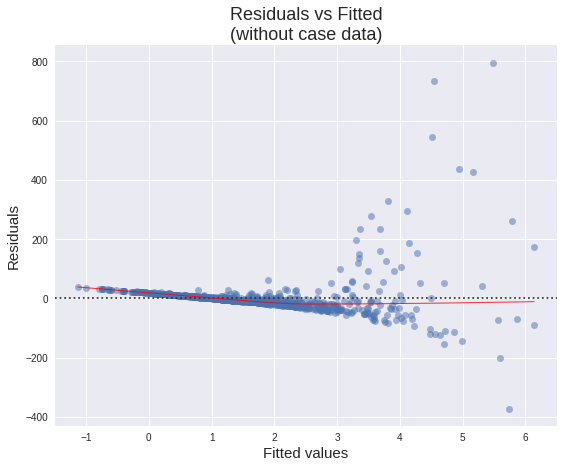

In [632]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam.loc[exam["deaths"]<5000,"fitted_noCases"], 
                                  exam.loc[exam["deaths"]<5000,"residuals_noCases"], 
                                  data=exam.loc[exam["deaths"]<5000,],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted\n(without case data)')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

# same sort of heteroskedasticity as with case data

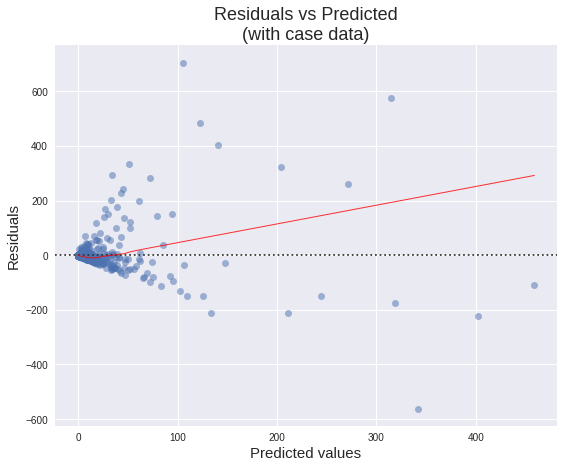

In [633]:
plot_lm_1 = plt.figure(figsize=(9,7))
plot_lm_1.axes[0] = sns.residplot(exam.loc[exam["deaths"]<5000,"pred"], 
                                  exam.loc[exam["deaths"]<5000,"residuals"], 
                                  data=exam.loc[exam["deaths"]<5000,],
                          lowess=True,
                          scatter_kws={'alpha': 0.5},
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Predicted\n(with case data)')
plot_lm_1.axes[0].set_xlabel('Predicted values')
plot_lm_1.axes[0].set_ylabel('Residuals');

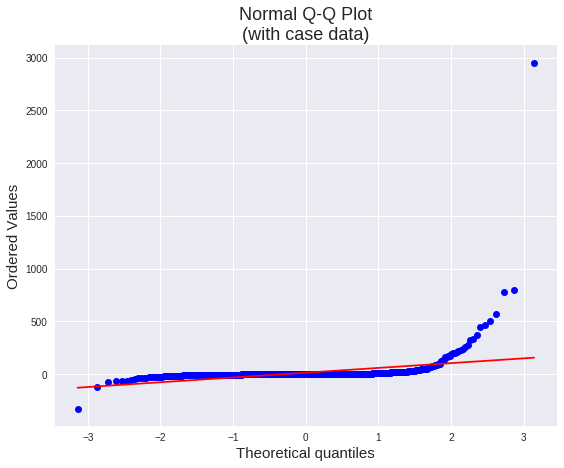

In [635]:
plt.figure(figsize=(9,7))
stats.probplot(exam["residuals"], dist="norm", 
                                   plot=plt)

plt.title('Normal Q-Q Plot\n(with case data)');

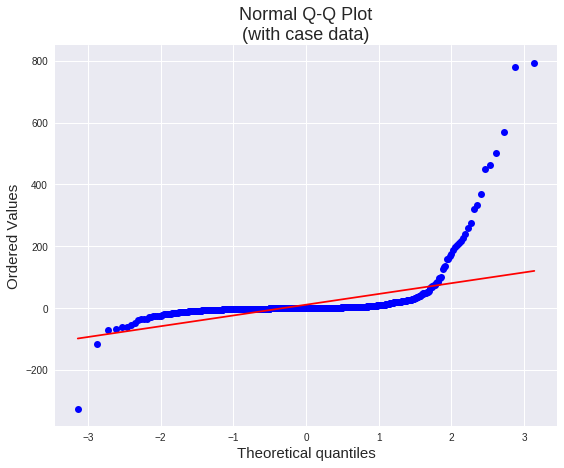

In [636]:
plt.figure(figsize=(9,7))
stats.probplot(exam.loc[exam["county"] != "New York County","residuals"], dist="norm", 
                                   plot=plt)

plt.title('Normal Q-Q Plot\n(with case data)');
# without NYC

Text(0.5, 0, 'Fitted value')

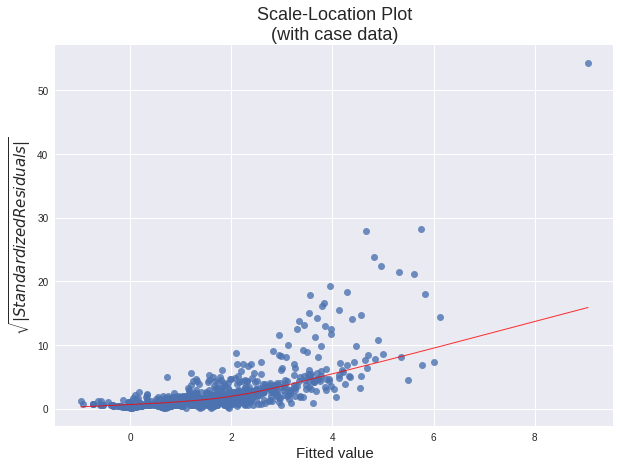

In [637]:
exam["norm_residuals_abs_sqrt"]=np.sqrt(np.abs(exam["residuals"]))

plt.figure(figsize=(10,7))
sns.regplot(exam["fitted"], exam["norm_residuals_abs_sqrt"],
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.title("Scale-Location Plot\n(with case data)")
plt.ylabel("$\sqrt{|Standardized Residuals|}$")
plt.xlabel("Fitted value")

### Elastic Net

In [392]:
encv = ElasticNetCV(normalize=True, max_iter=60000, random_state=101, cv=5)
encv.fit(abbrev[predictors], abbrev["deaths"])

ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=60000, n_alphas=100, n_jobs=None,
             normalize=True, positive=False, precompute='auto',
             random_state=101, selection='cyclic', tol=0.0001, verbose=0)

In [393]:
encv.score(abbrev[predictors], abbrev["deaths"])
# nowhere near .795

# with cv=5, r2=0.196
# with cv=3, r2=0.158
# with cv=7, r2=0.196
# with cv=10, r2=0.196

0.19587609278319817

In [394]:
# try without outlier NYC (collapsed into NY County)
encv = ElasticNetCV(normalize=True, max_iter=6000, random_state=1001, cv=5)
encv.fit(abbrev.loc[abbrev["county"] != "New York County", predictors], 
        abbrev.loc[abbrev["county"] != "New York County", "deaths"])
encv.score(abbrev.loc[abbrev["county"] != "New York County", predictors], 
          abbrev.loc[abbrev["county"] != "New York County", "deaths"])
# slightly better

0.36338563645011906

In [395]:
ttr_encv = TransformedTargetRegressor(regressor=ElasticNetCV(normalize=True, 
                                                            max_iter=6000, 
                                                            random_state=1001, cv=3), 
                                      func=np.log1p, inverse_func=np.expm1)
ttr_encv.fit(abbrev[predictors], abbrev["deaths"])
ttr_encv.score(abbrev[predictors], abbrev["deaths"])
# yikes

-6.915624696448504

In [396]:
# try with log-transformed independent variables + transformed dependent variable
ttr_encv = TransformedTargetRegressor(regressor=ElasticNetCV(normalize=True, 
                                                            max_iter=6000, 
                                                            random_state=1001, cv=3), 
                                      func=np.log1p, inverse_func=np.expm1)
ttr_encv.fit(abbrev[log_predictors], abbrev["deaths"])

TransformedTargetRegressor(check_inverse=True, func=<ufunc 'log1p'>,
                           inverse_func=<ufunc 'expm1'>,
                           regressor=ElasticNetCV(alphas=None, copy_X=True,
                                                  cv=3, eps=0.001,
                                                  fit_intercept=True,
                                                  l1_ratio=0.5, max_iter=6000,
                                                  n_alphas=100, n_jobs=None,
                                                  normalize=True,
                                                  positive=False,
                                                  precompute='auto',
                                                  random_state=1001,
                                                  selection='cyclic',
                                                  tol=0.0001, verbose=0),
                           transformer=None)

In [397]:
ttr_encv.score(abbrev[log_predictors], abbrev["deaths"])
# better than the non-transformed dependent variable training

0.6006040674487356

#### ElasticNet with GridSearchCV

In [398]:
param_grid = [{'l1_ratio':[0.1, 0.3, 0.5, 0.7, 0.9]}]
enm = ElasticNet(normalize=True, max_iter=60000, random_state=1001)
scorer = make_scorer(r2_score)
search = GridSearchCV(enm, param_grid, cv=3, scoring=scorer).fit(abbrev[predictors], abbrev["deaths"])

In [399]:
search

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=60000, normalize=True,
                                  positive=False, precompute=False,
                                  random_state=1001, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(r2_score), verbose=0)

In [400]:
search.best_estimator_ 

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.9,
           max_iter=60000, normalize=True, positive=False, precompute=False,
           random_state=1001, selection='cyclic', tol=0.0001, warm_start=False)

In [401]:
search.best_score_
# yikes, not good, ElasticNetCV 
# with CV=10 l1_ratio=0.9, score=0.0373
# with CV=5 l1_ratio=0.9, score=0.0544
# with CV=3 l1_ratio=0.9, score=0.0793

0.07931775070155102

In [402]:
# try transformed target model with l1_ratio found in grid search

ttr_encv = TransformedTargetRegressor(regressor=ElasticNetCV(l1_ratio=0.9,
                                                             normalize=True, 
                                                             max_iter=6000, 
                                                             random_state=1001, cv=3), 
                                      func=np.log1p, inverse_func=np.expm1)
ttr_encv.fit(abbrev[predictors], abbrev["deaths"])
ttr_encv.score(abbrev[predictors], abbrev["deaths"])

-4.263819357230285

In [403]:
ttr_encv = TransformedTargetRegressor(regressor=ElasticNetCV(l1_ratio=0.9,
                                                             normalize=True, 
                                                             max_iter=6000, 
                                                             random_state=1001, cv=3), 
                                      func=np.log1p, inverse_func=np.expm1)
ttr_encv.fit(abbrev[log_predictors], abbrev["deaths"])
ttr_encv.score(abbrev[log_predictors], abbrev["deaths"])

# not too far off from the default l1_ratio (0.5)

0.5711049430003712